# **Data Pre-Processing**

In [18]:
import pandas as pd

file = pd.read_csv("D:/Google Scholar Resources.csv")

# If 'Citations' column exists, process it; otherwise skip the filtering step
if 'Citations' in file.columns:
    # Ensure 'Citations' column is numeric
    file['Citations'] = pd.to_numeric(file['Citations'], errors='coerce')

    # Drop rows with missing citation values
    file = file.dropna(subset=['Citations'])

    # Filter top 30% by citations
    threshold = file['Citations'].quantile(0.70)
    df = file[file['Citations'] > threshold].reset_index(drop=True)

else:
    df = file.copy().reset_index(drop=True)


In [19]:
df.columns

Index(['Title', 'Abstract', 'Authors', 'Year', 'URL', 'Citations', 'Journal'], dtype='object')

In [20]:
df.head()

,Title,Abstract,Authors,Year,URL,Citations,Journal
0,High-performance medicine: the convergence of ...,NaN,E. Topol,2019,https://www.semanticscholar.org/paper/f134abea...,4040,Nature Medicine
1,Explainable Artificial Intelligence (XAI): Con...,NaN,"Alejandro Barredo Arrieta, Natalia Díaz Rodríg...",2019,https://www.semanticscholar.org/paper/530a059c...,5841,Inf. Fusion
2,Explanation in Artificial Intelligence: Insigh...,NaN,Tim Miller,2017,https://www.semanticscholar.org/paper/e89dfa30...,4081,Artif. Intell.
3,Sparks of Artificial General Intelligence: Ear...,Artificial intelligence (AI) researchers have ...,"Sébastien Bubeck, Varun Chandrasekaran, Ronen ...",2023,https://www.semanticscholar.org/paper/8dbd5746...,2793,ArXiv
4,Peeking Inside the Black-Box: A Survey on Expl...,At the dawn of the fourth industrial revolutio...,"Amina Adadi, M. Berrada",2018,https://www.semanticscholar.org/paper/21dff47a...,3662,IEEE Access


In [21]:
df.shape

(30630, 7)

In [22]:
# Determine the best text column to use
# It will be usefull for datasets like "Youtube" which does not have abstract
text_column = "Abstract" if "Abstract" in df.columns else "Title"
text_column

'Abstract'

In [23]:
if "Abstract" in df.columns and "Title" in df.columns:
    df["Abstract"] = df["Abstract"].fillna(df["Title"])
else:
    print("'Abstract' column missing or only 'Title' is available. Please skipping fill.")

# **Text Embedding Using Bert**

In [24]:
from sentence_transformers import SentenceTransformer

# Method adapted from:
# Rahultiwari.(2024). Unlocking the Power of Sentence Embeddings with all-MiniLM-L6-v2. Medium
# Retrieved from https://medium.com/@rahultiwari065/unlocking-the-power-of-sentence-embeddings-with-all-minilm-l6-v2-7d6589a5f0aa

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [25]:
import spacy
import pandas as pd

# Load English language model
nlp = spacy.load("en_core_web_sm")

def lemmatization(text):
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

df['lemmatized_text'] = df[text_column].apply(lemmatization)



In [26]:
import re

# Preprocess text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df[text_column] = df['lemmatized_text'].fillna("").apply(clean_text)

# Generate embeddings efficiently
print("Generating text embeddings...")
embeddings = model.encode(df[text_column].tolist(), batch_size=128, show_progress_bar=True)

Generating text embeddings...


Batches: 100%|██████████| 240/240 [16:18<00:00,  4.08s/it]


In [27]:
embeddings.shape

(30630, 384)

# **Dimantiality Reduction Using Autoencoder in Pytorch**
In this part, we implements an autoencoder using PyTorch to compress high-dimensional BERT embeddings into a lower-dimensional latent space. The Autoencoder class defines a symmetrical neural network with two hidden layers in both the encoder and decoder, using ReLU activations. The training function trainAutoencoder minimizes mean squared reconstruction loss between the input and output embeddings while tracking both training and validation loss to monitor overfitting. The model is trained on a split of the data, and losses are plotted for interpretability. A reproducibility function is also included to ensure consistent results across runs by fixing seeds for all relevant libraries.

Once training is complete, the autoencoder is used to encode the entire dataset into compressed vectors and reconstruct the original input. The reconstruction quality is evaluated by computing mean squared errors per sample, and poorly reconstructed samples (above the 95th percentile) are flagged. These errors are visualized as a histogram, while the loss history is plotted to show training dynamics. The final output includes the encoded vectors, reconstructed data, reconstruction errors, and indices of outliers, which can be used in downstream tasks.

Epoch 0: Train Loss = 0.001376, Val Loss = 0.001030
Epoch 10: Train Loss = 0.000910, Val Loss = 0.000911
Epoch 20: Train Loss = 0.000889, Val Loss = 0.000892
Epoch 30: Train Loss = 0.000877, Val Loss = 0.000880
Epoch 40: Train Loss = 0.000863, Val Loss = 0.000865

Number of poorly reconstructed samples: 1532


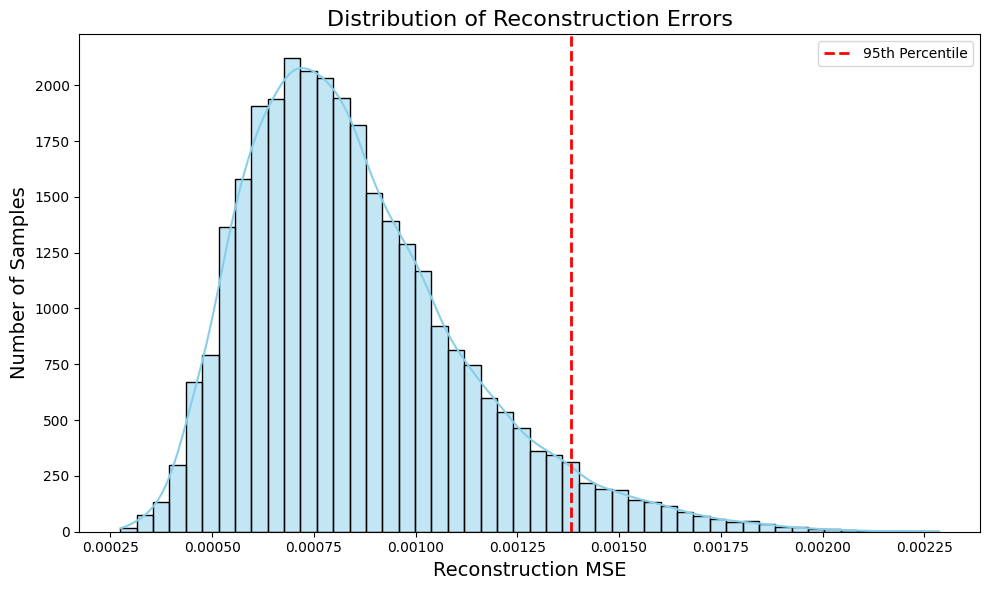

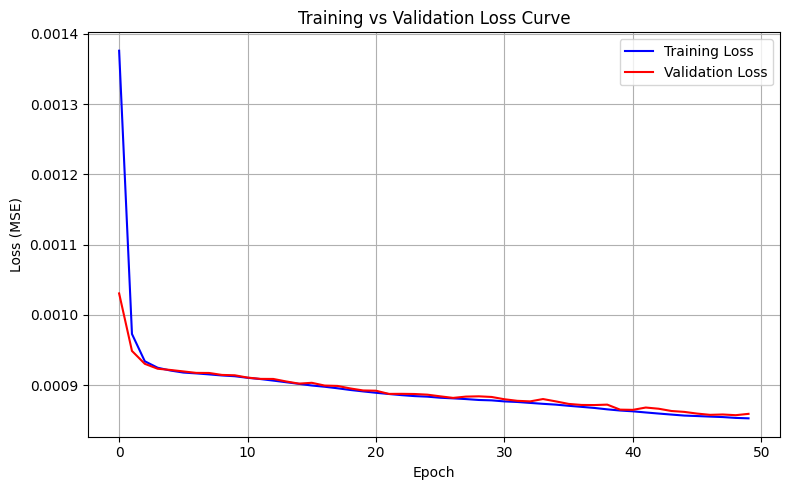

In [28]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Method adapted from:
# GeeksforGeeks.(2025). Implementing an Autoencoder in PyTorch. Retrieved from https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

# Reproducibility Setup fuction
def setRandomSeed(seed=42):
    """
    Sets seeds across libraries to ensure reproducibility of results.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)



# Autoencoder Model function
class Autoencoder(nn.Module):
    """
    Defines a simple symmetric autoencoder using two fully connected layers
    for both encoding and decoding.
    """
    def __init__(self, input_dim, encoding_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),  # First layer reduces to 128
            nn.ReLU(),
            nn.Linear(128, encoding_dim),  # Bottleneck layer
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Expand back from bottleneck
            nn.ReLU(),
            nn.Linear(128, input_dim)  # Final output layer (same size as input)
        )

    def forward(self, x):
        """
        Defines the forward pass through encoder and decoder.
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Training Function
def trainAutoencoder(model, data_tensor, epochs=50, batch_size=32, learning_rate=0.001, val_ratio=0.2):
    """
    Trains the autoencoder with validation loss monitoring.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Split data into training and validation
    data_np = data_tensor.cpu().numpy()
    train_data, val_data = train_test_split(data_np, test_size=val_ratio, random_state=42)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).to(data_tensor.device)
    val_tensor = torch.tensor(val_data, dtype=torch.float32).to(data_tensor.device)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss 
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_tensor).item()
        val_losses.append(val_loss)
        model.train()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}, Val Loss = {val_loss:.6f}")

    return model, train_losses, val_losses



# Evaluation & Visualization function
def evaluateReconstruction(original_data, reconstructed_data, threshold_percentile=95):
    """
    Computes reconstruction errors and identifies poorly reconstructed samples
    based on a percentile threshold.
    """
    original_np = original_data.detach().cpu().numpy()
    reconstructed_np = reconstructed_data.detach().cpu().numpy()

    # MSE per sample
    errors = np.mean((original_np - reconstructed_np) ** 2, axis=1)

    # Threshold at the given percentile (set as 95%)
    threshold = np.percentile(errors, threshold_percentile)

    # Indices where reconstruction error is greater than threshold
    outlier_indices = np.where(errors > threshold)[0]

    return errors, threshold, outlier_indices


def plotErrors(errors):
    """
    Visualizes the distribution of reconstruction errors.
    Highlights the 95th percentile cutoff for detecting poor reconstructions.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.axvline(np.percentile(errors, 95), color='red', linestyle='--', linewidth=2, label='95th Percentile')
    plt.title("Distribution of Reconstruction Errors", fontsize=16)
    plt.xlabel("Reconstruction MSE", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plotLossCurve(train_losses, val_losses):
    """
    Plots both training and validation loss curves.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Main Function
def main(embedding_vectors_np):
    """
    Main pipeline to:
    - Prepare data
    - Train autoencoder
    - Generate encoded & reconstructed vectors
    - Evaluate reconstruction quality
    - Plot errors and training performance
    """

    global autoencoder, device 
    
    # Ensure reproducibility
    setRandomSeed(42)

    input_dim = embedding_vectors_np.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert input data to torch tensor
    data_tensor = torch.tensor(embedding_vectors_np, dtype=torch.float32).to(device)

    # Build and train autoencoder
    model = Autoencoder(input_dim=input_dim, encoding_dim=64).to(device)
    model, train_loss, val_loss = trainAutoencoder(model, data_tensor)

    
    # Set model as global encoder for use in search engine
    autoencoder = model

    # Switch to evaluation mode for inference
    model.eval()
    with torch.no_grad():
        encoded = model.encoder(data_tensor)           # Get bottleneck representations
        reconstructed = model(data_tensor)             # Reconstruct input

    # Analyze reconstruction quality
    errors, threshold, outliers = evaluateReconstruction(data_tensor, reconstructed)
    print(f"\nNumber of poorly reconstructed samples: {len(outliers)}")

    # Visualizations
    plotErrors(errors)
    plotLossCurve(train_loss, val_loss)


    return encoded.cpu().numpy(), reconstructed.cpu().numpy(), errors, outliers

# Run the Full Pipeline
data, reconstructed, reconstruction_errors, bad_indices = main(embeddings)


In [29]:
print(data.shape)

(30630, 64)


# **Find The Best Number Of Components For KMeans Based On WSS and silhouette Score**

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Initialize lists to store WCSS and Silhouette Scores
wcss = []
silhouette_scores = []

# Define the range of cluster numbers from 3 to 30 to test
K_nums = range(3, 31)

# Iterate over different values of k to evaluate clustering performance
for k in K_nums:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)

    wcss.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


c:\Users\ehsan\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ehsan\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\ehsan\anaconda3\envs\myenv\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\ehsan\anaconda3\envs\myenv\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ehsan\anaconda3\envs\myenv\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executabl

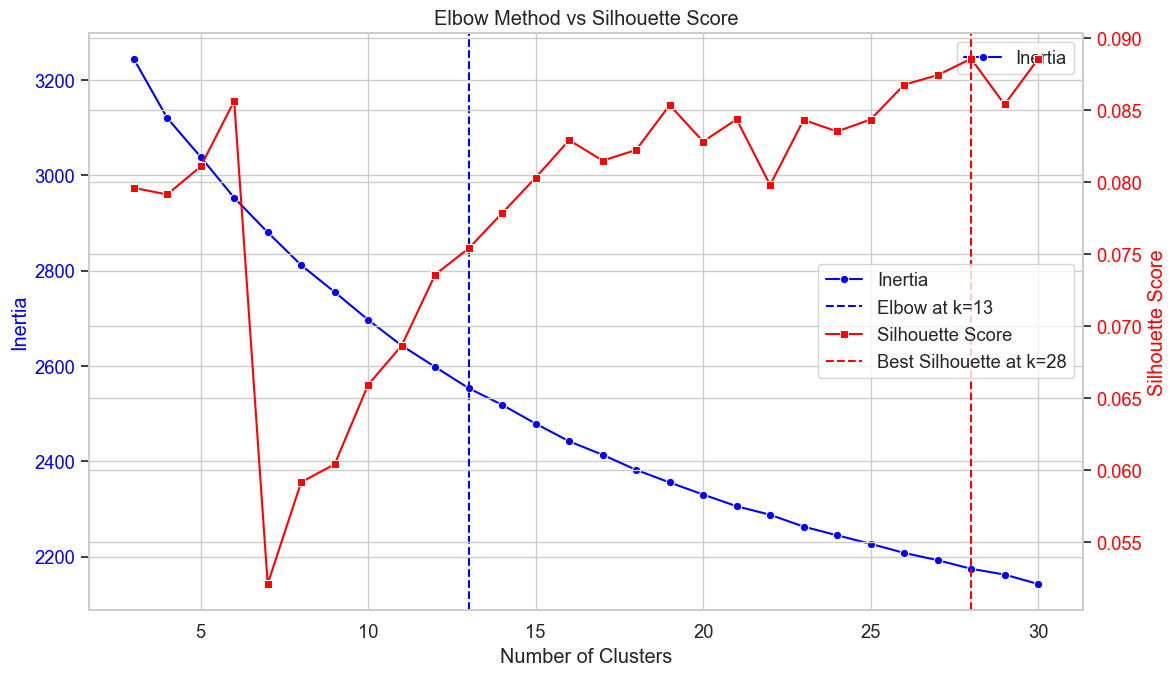

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

# Set seaborn settings
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Find the best elbow point
kneedle = KneeLocator(K_nums, wcss, curve='convex', direction='decreasing')
elbow_score = kneedle.elbow

# Find the best silhouette score
bestScore = K_nums[silhouette_scores.index(max(silhouette_scores))]

# Figure and twin axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot WCSS 
sns.lineplot(x=K_nums, y=wcss, marker='o', ax=ax1, label='Inertia', color='blue')
ax1.axvline(elbow_score, color='blue', linestyle='--', label=f'Elbow at k={elbow_score}')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create twin axis for silhouette
ax2 = ax1.twinx()
sns.lineplot(x=K_nums, y=silhouette_scores, marker='s', ax=ax2, label='Silhouette Score', color='red')
ax2.axvline(bestScore, color='red', linestyle='--', label=f'Best Silhouette at k={bestScore}')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Add title and layout tweaks
plt.title('Elbow Method vs Silhouette Score')
plt.tight_layout()
plt.show()


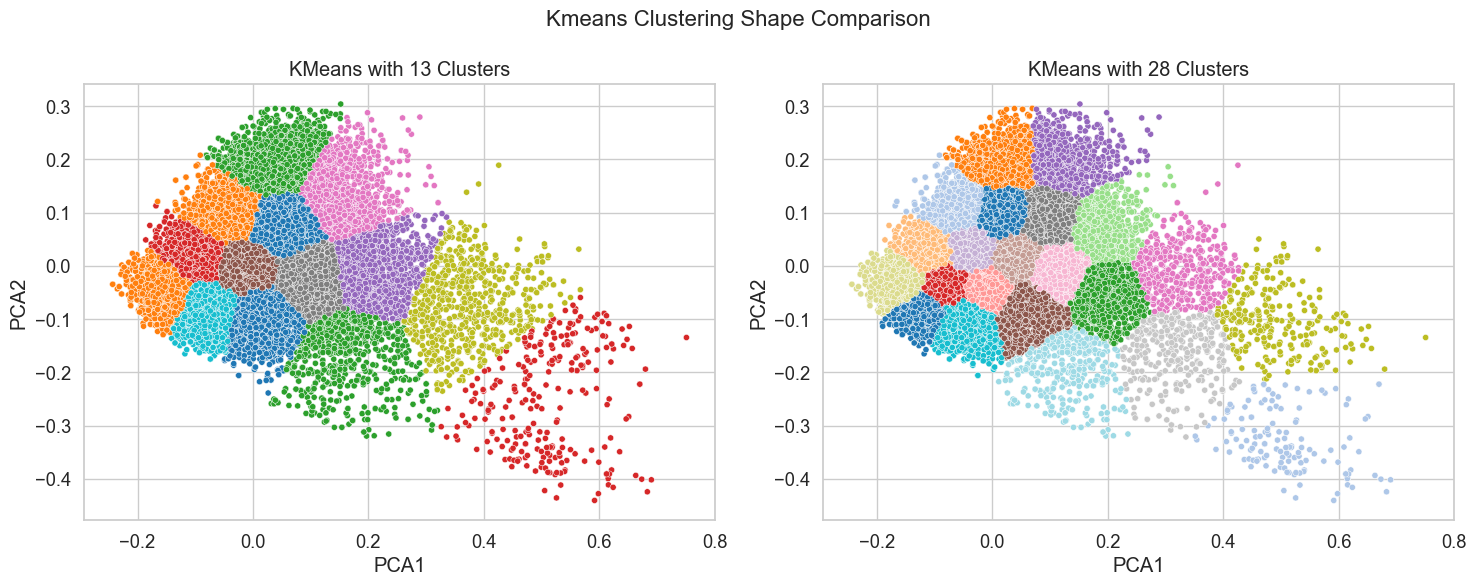

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reduce data to 2D 
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(data)

# Create a DataFrame with the 2D coordinates
pca_df = pd.DataFrame(pca_embeddings, columns=["PCA1", "PCA2"])

# Fit KMeans with 12 and 23 clusters
kmeans_13 = KMeans(n_clusters=14, n_init='auto', random_state=42).fit(pca_embeddings)
kmeans_28 = KMeans(n_clusters=22, n_init='auto', random_state=42).fit(pca_embeddings)

# Add cluster labels to the DataFrame
pca_df["Cluster_13"] = kmeans_13.labels_.astype(str)
pca_df["Cluster_28"] = kmeans_28.labels_.astype(str)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Cluster_13", palette="tab10", s=20, ax=axes[0], legend=False)
axes[0].set_title("KMeans with 13 Clusters")

sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Cluster_28", palette="tab20", s=20, ax=axes[1], legend=False)
axes[1].set_title("KMeans with 28 Clusters")

plt.suptitle("Kmeans Clustering Shape Comparison", fontsize=16)
plt.tight_layout()
plt.show()


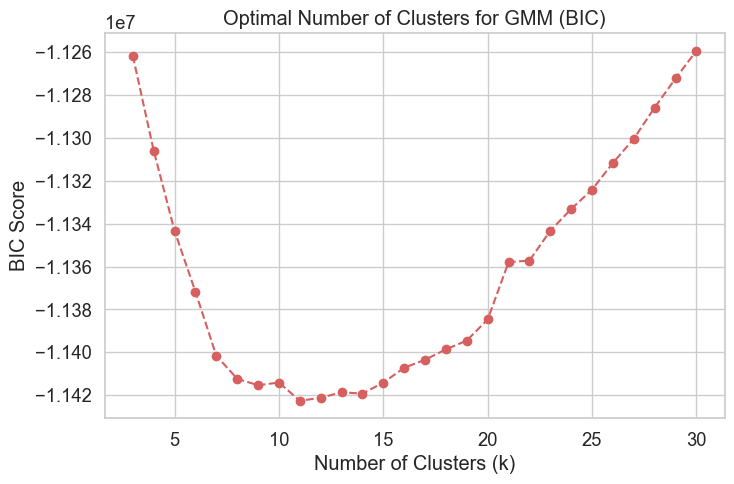

In [33]:
from sklearn.mixture import GaussianMixture

bic_scores = []  # Initialize an empty list to store BIC scores

for k in range(3, 31):  # Iterate over different numbers of clusters (from 3 to 30)
    gmm = GaussianMixture(n_components=k, random_state=42)  # Initialize Gaussian Mixture Model with k clusters
    gmm.fit(data)  # Fit the model to the RFM data
    bic_scores.append(gmm.bic(data))  # Compute and store the Bayesian Information Criterion (BIC) score


# Plot BIC scores
plt.figure(figsize=(8, 5))
plt.plot(range(3, 31), bic_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("Optimal Number of Clusters for GMM (BIC)")
plt.show()


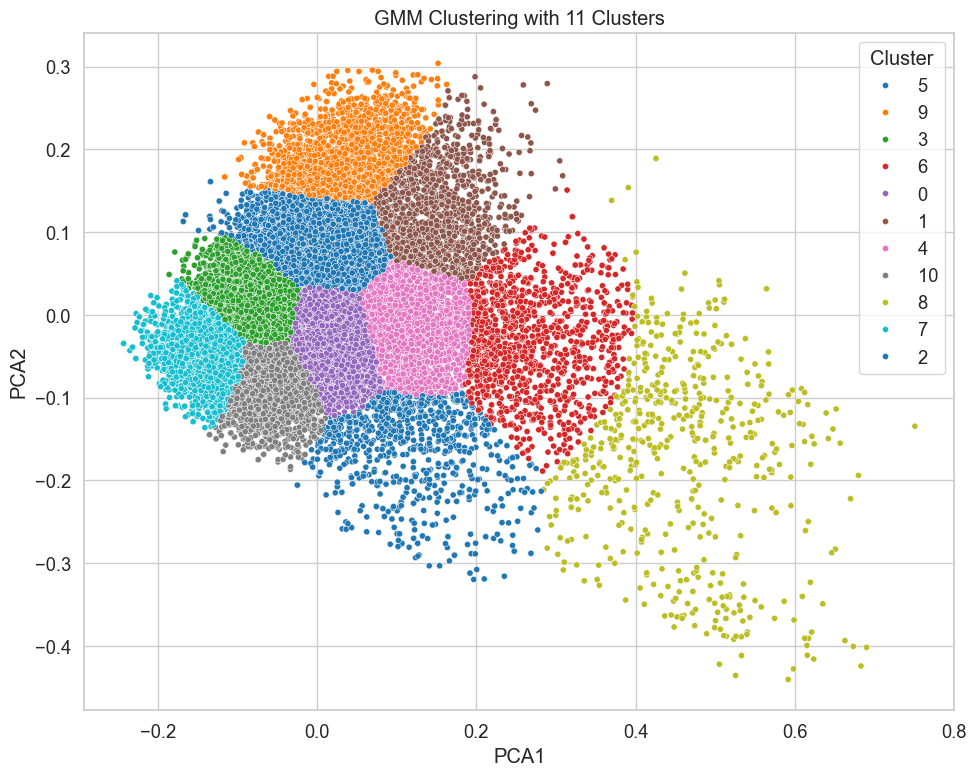

In [39]:

# Fit GMM with 13 clusters
gmm_13 = GaussianMixture(n_components=11, random_state=42).fit(pca_embeddings)

# Predict cluster labels
pca_df["Cluster"] = gmm_13.predict(pca_embeddings).astype(str)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=20, legend="full")
plt.title("GMM Clustering with 11 Clusters")
plt.tight_layout()
plt.show()


# **Keywords Extraction**

This method combines Kmeans Model clustering with TF-IDF-based keyword extraction to uncover the main themes within a corpus of text data. First, documents are embedded and reduced (using BERT + autoencoder), and then clustered into semantically coherent groups using KMeans. After clustering, a TfidfVectorizer is applied to the original text to identify the most representative terms for each cluster. By averaging TF-IDF scores within each group, the top keywords are extracted—offering interpretable insights into the semantic focus of each cluster. The goal is to automatically group and summarize documents by topic without manual labeling.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Method adopted from:
# Geeksforgeeks.(2024).Mastering TF-IDF Calculation with Pandas DataFrame in Python.
# Retrieved from https://www.geeksforgeeks.org/mastering-tf-idf-calculation-with-pandas-dataframe-in-python/

# Fit kmeans model on the data
KMeans = KMeans(n_clusters=bestScore, random_state=42)
KMeans_labels = KMeans.fit_predict(data)

# Assign cluster labels to the DataFrame
df["Cluster"] = KMeans_labels

# Initialize TF-IDF vectorizer (ignoring common English stopwords and limiting features to 2000)
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

# Transform the original text data into a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(df[text_column])

# Get the list of feature names (The words in the TF-IDF vocab)
terms = vectorizer.get_feature_names_out()

top_n = 10  # Number of top keywords to extract per cluster
cluster_keywords = {}

# Loop over each cluster to find top keywords
for cluster_num in sorted(df["Cluster"].unique()):
    # Get the indices of documents in the current cluster
    cluster_indices = df[df["Cluster"] == cluster_num].index.to_list()

    # Compute the mean TF-IDF score for each word across all docs in the cluster
    cluster_tfidf = X_tfidf[cluster_indices].mean(axis=0)

    # Convert sparse matrix to a flat NumPy array
    cluster_array = np.squeeze(np.asarray(cluster_tfidf))

    # Get indices of the top n highest scoring words
    top_words = cluster_array.argsort()[::-1][:top_n]

    # Retrieve the actual words corresponding to those indices
    keywords = [terms[i] for i in top_words]

    # Store the keywords for this cluster
    cluster_keywords[cluster_num] = keywords

# Print the top keywords for each cluster
for cluster, keywords in cluster_keywords.items():
    print(f"\n🔹Cluster {cluster} — Top Keywords:")
    print(", ".join(keywords))



🔹Cluster 0 — Top Keywords:
reinforcement, learning, policy, agent, rl, learn, task, reward, environment, algorithm

🔹Cluster 1 — Top Keywords:
learning, label, learn, supervised, shot, image, representation, semi, class, datum

🔹Cluster 2 — Top Keywords:
galaxy, star, cluster, mass, model, formation, spectral, density, matter, optical

🔹Cluster 3 — Top Keywords:
vector, support, machine, svm, svms, classification, algorithm, use, prediction, base

🔹Cluster 4 — Top Keywords:
topic, sentiment, text, model, document, word, user, classification, use, twitter

🔹Cluster 5 — Top Keywords:
online, student, learning, education, learn, study, course, teaching, teacher, research

🔹Cluster 6 — Top Keywords:
language, model, task, bert, transformer, llm, large, text, sentence, train

🔹Cluster 7 — Top Keywords:
material, diffusion, energy, model, molecular, chemical, machine, density, molecule, property

🔹Cluster 8 — Top Keywords:
machine, tree, algorithm, learning, classification, decision, learn,

In [36]:
# Count how many non-zero TF-IDF terms each cluster has
for cluster_num in sorted(df["Cluster"].unique()):
    cluster_indices = df[df["Cluster"] == cluster_num].index.to_list()
    cluster_tfidf = X_tfidf[cluster_indices].mean(axis=0)
    cluster_array = np.squeeze(np.asarray(cluster_tfidf))

    nonzero_count = np.count_nonzero(cluster_array)
    print(f"🔹 Cluster {cluster_num} has {nonzero_count} non-zero TF-IDF keywords.")


🔹 Cluster 0 has 1752 non-zero TF-IDF keywords.
🔹 Cluster 1 has 1785 non-zero TF-IDF keywords.
🔹 Cluster 2 has 1287 non-zero TF-IDF keywords.
🔹 Cluster 3 has 1529 non-zero TF-IDF keywords.
🔹 Cluster 4 has 1810 non-zero TF-IDF keywords.
🔹 Cluster 5 has 1602 non-zero TF-IDF keywords.
🔹 Cluster 6 has 1893 non-zero TF-IDF keywords.
🔹 Cluster 7 has 1586 non-zero TF-IDF keywords.
🔹 Cluster 8 has 1874 non-zero TF-IDF keywords.
🔹 Cluster 9 has 1768 non-zero TF-IDF keywords.
🔹 Cluster 10 has 1840 non-zero TF-IDF keywords.
🔹 Cluster 11 has 1904 non-zero TF-IDF keywords.
🔹 Cluster 12 has 1879 non-zero TF-IDF keywords.
🔹 Cluster 13 has 1863 non-zero TF-IDF keywords.
🔹 Cluster 14 has 1835 non-zero TF-IDF keywords.
🔹 Cluster 15 has 1770 non-zero TF-IDF keywords.
🔹 Cluster 16 has 1696 non-zero TF-IDF keywords.
🔹 Cluster 17 has 1677 non-zero TF-IDF keywords.
🔹 Cluster 18 has 1781 non-zero TF-IDF keywords.
🔹 Cluster 19 has 1752 non-zero TF-IDF keywords.
🔹 Cluster 20 has 1850 non-zero TF-IDF keywords.
🔹 

# **Implementatiom**

The following method combines semantic embeddings, dimensionality reduction, and hierarchical clustering to retrieve relevant documents based on a user's query. First, each document is encoded using a Sentence-BERT model to capture deep semantic meaning. These high-dimensional embeddings are then compressed using an autoencoder, which reduces noise and preserves core structure. Kmeans Model is applied to the  embeddings to group documents into high-level semantic clusters. When a user submits a query, it undergoes the same encoding and reduction process, is assigned to a cluster, and is compared to the cluster's documents using cosine similarity. A second layer of clustering is then applied to document titles to refine the results even further, ensuring that the final recommendations are both thematically and topically relevant.



In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch

# Assign raw embeddings and reduced vectors
df["Embeddings"] = list(embeddings)          # Raw BERT embeddings
df["ReducedEmbeddings"] = list(data)         # Reduced vectors from autoencoder

# First-level clustering using reduced embeddings
kmeans_model = KMeans(n_clusters=bestScore, n_init='auto', random_state=42)
df["Cluster"] = kmeans_model.fit_predict(data)

# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define which text column is being used ("Title" or "Abstract")
text_column = "Title"  # or "Abstract"

def search_similar_resources(query, df, top_n=10, min_similarity=0.50, title_cluster_k=3):
    if not query.strip():
        print("Query is empty. Please enter valid keywords.")
        return pd.DataFrame()

    # Encode and reduce query
    query_embedding = model.encode([query])

    autoencoder.eval()
    with torch.no_grad():
        query_tensor = torch.tensor(query_embedding, dtype=torch.float32).to(device)
        query_embedding_reduced = autoencoder.encoder(query_tensor).cpu().numpy()

    # Find most relevant main cluster
    query_cluster = kmeans_model.predict(query_embedding_reduced)[0]
    cluster_df = df[df["Cluster"] == query_cluster].copy()

    if cluster_df.empty:
        print("No relevant resources found in the identified cluster.")
        return pd.DataFrame()

    # Compute cosine similarity
    cluster_embeddings = np.vstack(cluster_df["Embeddings"].to_numpy())
    similarity_scores = cosine_similarity(query_embedding, cluster_embeddings).flatten()
    cluster_df["Similarity"] = similarity_scores
    cluster_df = cluster_df[cluster_df["Similarity"] >= min_similarity]

    if cluster_df.empty:
        print("No resources met the minimum similarity threshold.")
        return pd.DataFrame()

    # Title-Level Clustering if dataset has both abstract and title
    if text_column.lower() == "abstract":
        text_data = cluster_df["Title"].tolist()
        title_embeddings = model.encode(text_data)

        if len(title_embeddings) < title_cluster_k:
            title_cluster_k = max(1, len(title_embeddings))

        title_kmeans = KMeans(n_clusters=title_cluster_k, random_state=42)
        cluster_df["TitleCluster"] = title_kmeans.fit_predict(title_embeddings)

        query_title_embedding = model.encode([query])
        query_title_cluster = title_kmeans.predict(query_title_embedding)[0]

        cluster_df = cluster_df[cluster_df["TitleCluster"] == query_title_cluster].copy()
        if cluster_df.empty:
            print("No relevant titles found in the identified subcluster.")
            return pd.DataFrame()

    # Final selection
    # Handle error if the dataset has not URL column
    cluster_df = cluster_df.drop_duplicates(subset=["Title", "Similarity"])
    top_results = cluster_df.sort_values(by="Similarity", ascending=False).head(top_n)

    # Check if 'URL' exists before selecting it
    if "URL" in cluster_df.columns:
        return top_results[["Title", "URL", "Similarity"]]
    else:
        print("'URL' column not found. Returning results without URLs.")
        return top_results[["Title", "Similarity"]]


# User Interface
query = input("Enter keywords to search: ")
recommendations = search_similar_resources(query, df, top_n=10, min_similarity=0.50, title_cluster_k=3)


# **Print Out The Recommended Results**

In [44]:
from IPython.core.display import display, Markdown

def displayResults(recommendations):
    """
    Display search results as Markdown in Jupyter Notebook.
    Handles missing URL column gracefully.
    """
    if recommendations.empty:
        display(Markdown("**No results to display.**"))
        return

    output = "### Search Results:\n"
    url_exists = "URL" in recommendations.columns

    for index, row in recommendations.iterrows():
        title = row["Title"]
        score = row["Similarity"]
        
        if url_exists and pd.notna(row["URL"]):
            output += f"- **Title:** [{title}]({row['URL']})\n"
        else:
            output += f"- **Title:** {title}\n"
        
        output += f"  - **Similarity Score:** {score:.2f}\n\n"

    display(Markdown(output))

# Call function
displayResults(recommendations)


C:\Users\ehsan\AppData\Local\Temp\ipykernel_21656\793201726.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, Markdown


### Search Results:
- **Title:** [Principal component analysis: a review and recent developments](https://www.semanticscholar.org/paper/5bc875d65df812f9617d8ba508c1c85f4d219b19)
  - **Similarity Score:** 0.64

- **Title:** [Multivariate Statistical Data Analysis- Principal Component Analysis (PCA) -](https://www.semanticscholar.org/paper/3ad314f33dbdf486999f521ed3ba061006a2d2b2)
  - **Similarity Score:** 0.64

- **Title:** [Principal Component Analysis](https://www.semanticscholar.org/paper/ae7b96d287893d246313ccd0566cc4a17f863d44)
  - **Similarity Score:** 0.57

- **Title:** [ROBPCA: A New Approach to Robust Principal Component Analysis](https://www.semanticscholar.org/paper/250b4f05982b491ad80ba8b986d958eedb69a6be)
  - **Similarity Score:** 0.56

- **Title:** [Finite sample approximation results for principal component analysis: a matrix perturbation approach](https://www.semanticscholar.org/paper/7c0f5b508303c35da77fa775fa08fdfa5f6b37db)
  - **Similarity Score:** 0.55

- **Title:** [On Consistency and Sparsity for Principal Components Analysis in High Dimensions](https://www.semanticscholar.org/paper/6b0345fe5dbf7a8551edd7ae3f56f803fc21378a)
  - **Similarity Score:** 0.54

- **Title:** [A Randomized Algorithm for Principal Component Analysis](https://www.semanticscholar.org/paper/08a757bb53efafbb0eec6cd0a9ab3f128b6d01d3)
  - **Similarity Score:** 0.53

- **Title:** [Nonlinear principal components analysis: introduction and application.](https://www.semanticscholar.org/paper/5045d6690cb11379a68a1014a4c65ac3bcddbbdb)
  - **Similarity Score:** 0.53

- **Title:** [Sparse Principal Components Analysis](https://www.semanticscholar.org/paper/39ac586c519ef8569b4f401a257c29b2039d5d25)
  - **Similarity Score:** 0.53

- **Title:** [Conceptual and empirical comparison of dimensionality reduction algorithms (PCA, KPCA, LDA, MDS, SVD, LLE, ISOMAP, LE, ICA, t-SNE)](https://www.semanticscholar.org/paper/47a4c6773be86ea8a81ef996b1991ff61ce1c54c)
  - **Similarity Score:** 0.53

